#### Using ANN for detecting irregularities in Kubernete's clusters
Introduction:
After performing the Model Research, ANN (or Artificial Neural Networks) seemed to be a good fit for our case due to it's robustness, customizability and huge amounts of documentation available online. This notebook represents the implementation part, starting from Data Preparation and finishing with model hyperparameter tuning. 

In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import sklearn
import statistics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras import layers
from keras import losses
from keras import activations
from keras import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import nbformat
import shap
from nbconvert import HTMLExporter
from tensorflow import keras
from keras.layers import Dense
from keras.layers import Flatten
from keras.regularizers import l2
from keras.models import Model
from keras.layers import Dropout
from tensorflow.keras import regularizers
from keras.optimizers import SGD
from keras.applications.resnet50 import ResNet50
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2023-11-23 12:38:42.509233: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-23 12:38:43.148628: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-23 12:38:44.094511: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data preparation

#### Datasets analysis
The three datasets that we were provided are quite different from each other - some have more malicious data, while others have more benign entries, so the proportion of malicious/benign is different. It would be a good decision to merge them together into a large dataframe from the very beginning - more entries means more data variety, which increases model's ability to tackle different types of anomalies while decreasing the chance of overfitting.

#### Data cleaning
The dataset's quality is sufficient - there are no typecasting issues, where a string value ends up in an integer column. Moreover, the dataset values are clear and representative, without any predictions or approximations. 
#### Data processing


In [2]:
def data_squashing(dataset):
 new_set = dataset
 new_set = new_set.dropna()
 new_set['_source_@timestamp'] = pd.to_datetime(new_set['_source_@timestamp'])
 new_set['packets'] = np.ones(len(new_set))
 new_set['min_network_bytes'] = new_set['_source_network_bytes']
 new_set['max_network_bytes'] = new_set['_source_network_bytes']
 new_set['min_source_event_duration'] = new_set['_source_event_duration']
 new_set['max_source_event_duration'] = new_set['_source_event_duration']
 new_set['min_source_@timestamp'] = new_set['_source_@timestamp']
 new_set['max_source_@timestamp'] = new_set['_source_@timestamp']
 new_set = new_set.groupby(['_source_flow_id', '_source_source_ip', '_source_destination_ip'])
 squash_rules = {
    '_source_event_duration': 'sum',
    '_source_network_bytes': 'sum',
    'packets': 'sum',
    # Later addition for finding the deviation of byte data
    'min_network_bytes': 'min',
    'max_network_bytes': 'max',
    # Later addition for finding the deviation of event duration
    'min_source_event_duration': 'min',
    'max_source_event_duration': 'max',
    '_source_flow_final': 'mean',
    # Later addition for finding the deviation of timestamp
    'min_source_@timestamp': 'min',
    '_source_network_transport': 'first',
    'max_source_@timestamp': 'max',
    '_source_source_port': 'first',
    'label': 'first'
     
}
 new_set = new_set.agg(squash_rules).reset_index()
 return new_set
def data_preprocessing(dataset):
 dataset.set_index('_source_flow_id', inplace=True)
 #dataset.set_index('_source_flow_id', inplace=True)
 dataset['flow_duration_s'] = (dataset['max_source_@timestamp'] - dataset['min_source_@timestamp']).dt.seconds
 dataset.drop("_source_source_ip", inplace = True, axis = 1)
 dataset.drop("_source_destination_ip", inplace = True, axis = 1)
 dataset.drop("max_source_@timestamp", inplace = True, axis = 1)
 dataset.drop("min_source_@timestamp", inplace = True, axis = 1)
 print(dataset.columns.values)
 cols = ['_source_event_duration', '_source_network_bytes', 'packets',
 'min_network_bytes', 'max_network_bytes', 'min_source_event_duration',
 'max_source_event_duration', '_source_flow_final',
 '_source_network_transport', '_source_source_port',
 'flow_duration_s', 'label']
 dataset["label"] = dataset["label"].astype('category')
 dataset["_source_network_transport"] = dataset["_source_network_transport"].astype('category')

 dataset["label"] = dataset["label"].cat.codes
 dataset["_source_network_transport"] = dataset["_source_network_transport"].cat.codes
 
 dataset['_source_source_port'] = dataset['_source_source_port'].astype(int) 
 dataset = dataset[cols]
 return dataset
    
def prepare_the_dataset(path):
 dataset = pd.read_csv(path, sep = ",", verbose = 0)
 #dataset = data_cleaning(dataset)
 dataset = data_squashing(dataset)
 dataset = data_preprocessing(dataset)
 return dataset

In [3]:
#dataset = pd.read_csv('all_data.csv')
#dataset.loc[dataset['_source_flow_id'] == "EAD/////AP////////8AAAGsEAILrBACDA"]

In [4]:

#all_data = prepare_the_dataset('all_data.csv')
#malicious_data =  prepare_the_dataset('malicious.csv')
#remaining_data = prepare_the_dataset('benign.csv')
#frames = [all_data, malicious_data, remaining_data]
#all_data = pd.concat(frames)
#print("The merged dataset has ", len(all_data), " entries!") 
all_data = pd.read_csv('flow_data.csv')
all_data['duration'] = all_data['duration'] / pd.Timedelta(milliseconds=1)
print(all_data.columns.tolist())
cols = ['_source_flow_id', '_source_event_duration', '_source_network_bytes', 'packets', 
        'min_network_bytes', 'max_network_bytes', 'min_source_event_duration', 'max_source_event_duration', 
        'min_source_timestamp', 'max_source_timestamp', 'final_flow_count', 'duration', 'label']
all_data = all_data[cols]
all_data.set_index('_source_flow_id', inplace=True)
all_data.drop("max_source_timestamp", inplace = True, axis = 1)
all_data.drop("min_source_timestamp", inplace = True, axis = 1)
all_data['label'] = all_data['label'].replace(-1, 1)
all_data.head()

['_source_flow_id', '_source_event_duration', '_source_network_bytes', 'udp', 'tcp', 'packets', 'label', 'min_network_bytes', 'max_network_bytes', 'min_source_event_duration', 'max_source_event_duration', 'min_source_timestamp', 'max_source_timestamp', 'final_flow_count', 'duration']


,_source_event_duration,_source_network_bytes,packets,min_network_bytes,max_network_bytes,min_source_event_duration,max_source_event_duration,final_flow_count,duration,label
_source_flow_id,,,,,,,,,,
EAL/////AP////8I//8AAAEAAAAA/////0QAQwA,0,1690.0,5.0,338.0,338.0,0,0,1,40000.0,0
EAL/////AP////8I//8AAAEKAAICCgACD0MARAA,503552,23288.0,27.0,592.0,924.0,0,30254,5,310458337.0,0
EAL/////AP////8I//8AAAEKAAIDCgACDzUA+dU,1763084,744.0,4.0,186.0,186.0,440771,440771,1,30005.0,0
EAL/////AP////8I//8AAAEKAAIDCgACDzUA35Y,779242764,1208.0,4.0,302.0,302.0,194810691,194810691,1,29912.0,0
EAL/////AP////8I//8AAAEKAAIDCgACDzUA37U,0,558.0,6.0,93.0,93.0,0,0,1,49906.0,0


In [5]:
# For plotting histogram for a numeric feature
def compare_malicious_and_benign(malicious_col, benign_col):
    # Plot outcomes
    plt.figure(figsize=(12, 5))
    plt.xlabel("Value")
    plt.ylabel("Amount of samples")
    plt.hist(malicious_col, color = 'orange', label = "Malicious", alpha=0.45, bins = 50)
    plt.hist(benign_col, color = 'lightsteelblue', label = "Benign", alpha=0.45, bins = 50)
    plt.legend(loc="upper right")
    plt.show()


In [6]:
malicious = all_data[all_data['label'] == 1] 
benign = all_data[all_data['label'] == 0]

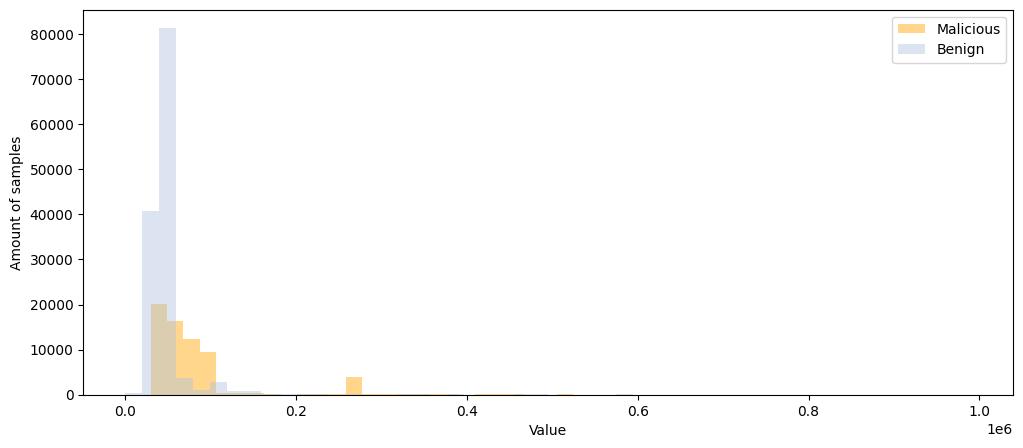

In [7]:
plot_packets = malicious['duration'].loc[malicious['duration'] < 1000000]
plot_packets_benign = benign['duration'].loc[benign['duration'] < 1000000]
compare_malicious_and_benign(plot_packets, plot_packets_benign)

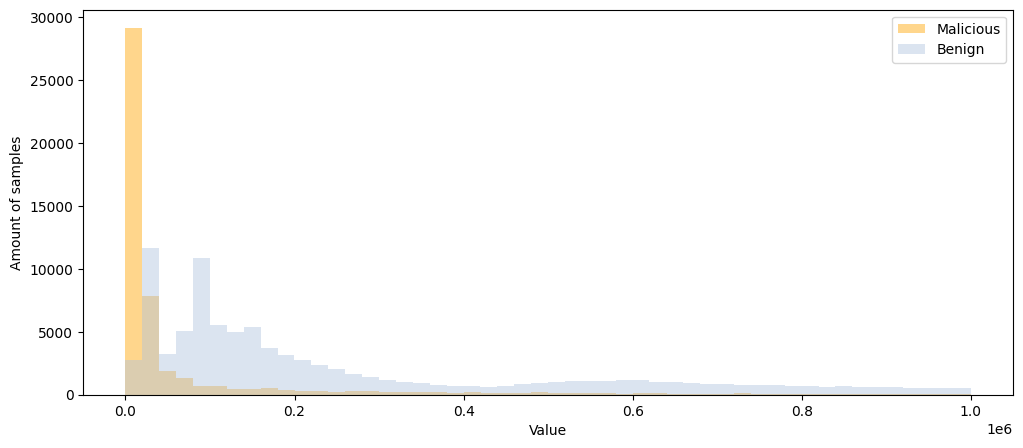

In [8]:
plot_packets = malicious['max_source_event_duration'].loc[malicious['max_source_event_duration'] < 1000000]
plot_packets_benign = benign['max_source_event_duration'].loc[benign['max_source_event_duration'] < 1000000]
compare_malicious_and_benign(plot_packets, plot_packets_benign)

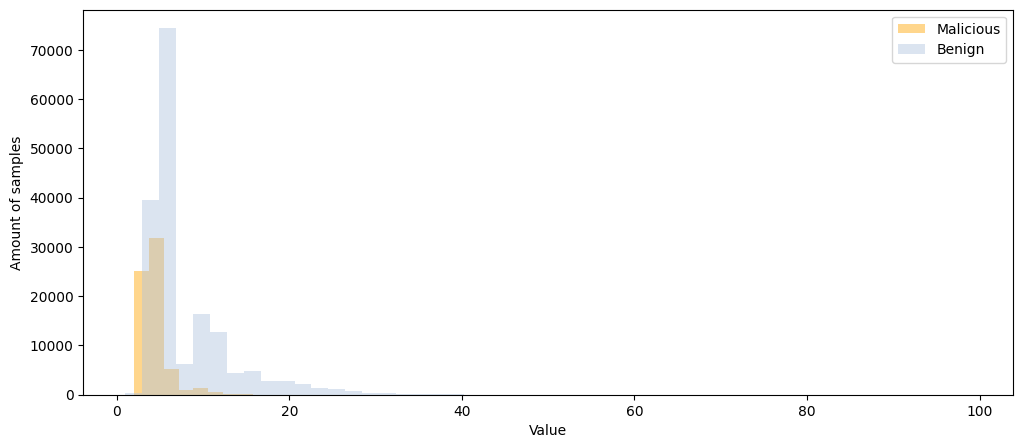

In [9]:
plot_packets = malicious['packets'].loc[malicious['packets'] < 100]
plot_packets_benign = benign['packets'].loc[benign['packets'] < 100]
compare_malicious_and_benign(plot_packets, plot_packets_benign)

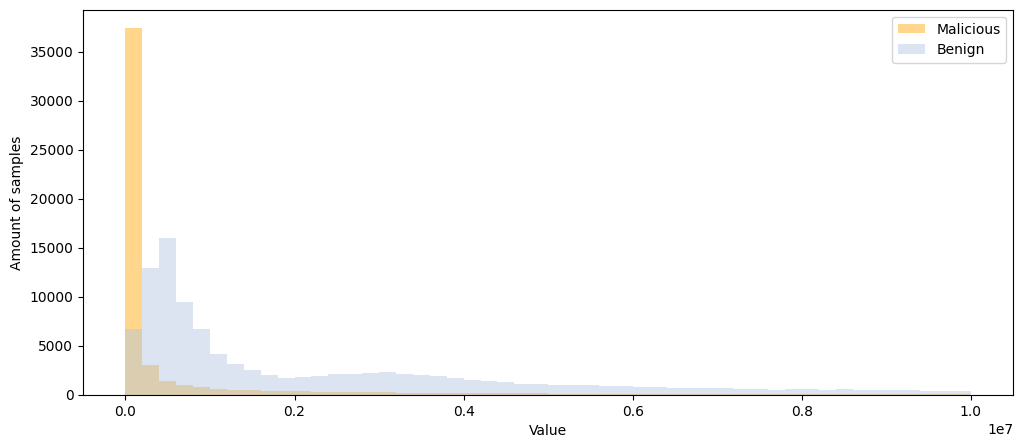

In [10]:
plot_packets = malicious['_source_event_duration'].loc[malicious['_source_event_duration'] < 10000000]
plot_packets_benign = benign['_source_event_duration'].loc[benign['_source_event_duration'] < 10000000]
compare_malicious_and_benign(plot_packets, plot_packets_benign)

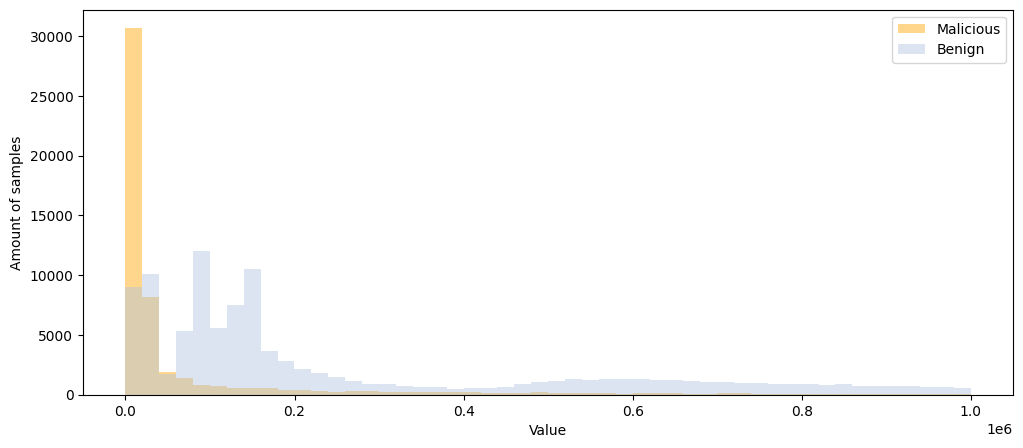

In [11]:
plot_packets = malicious['min_source_event_duration'].loc[malicious['min_source_event_duration'] < 1000000]
plot_packets_benign = benign['min_source_event_duration'].loc[benign['min_source_event_duration'] < 1000000]
compare_malicious_and_benign(plot_packets, plot_packets_benign)

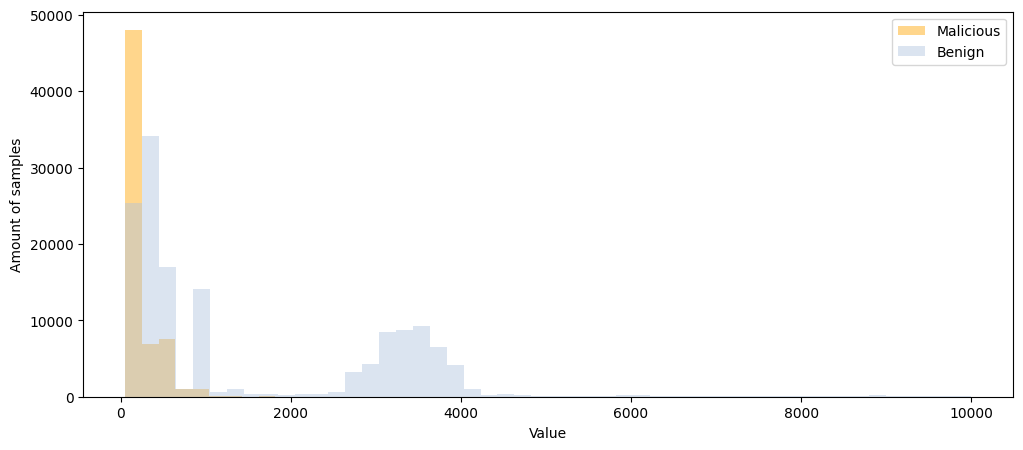

In [12]:
plot_packets = malicious['max_network_bytes'].loc[malicious['max_network_bytes'] < 10000]
plot_packets_benign = benign['max_network_bytes'].loc[benign['max_network_bytes'] < 10000]
compare_malicious_and_benign(plot_packets, plot_packets_benign)

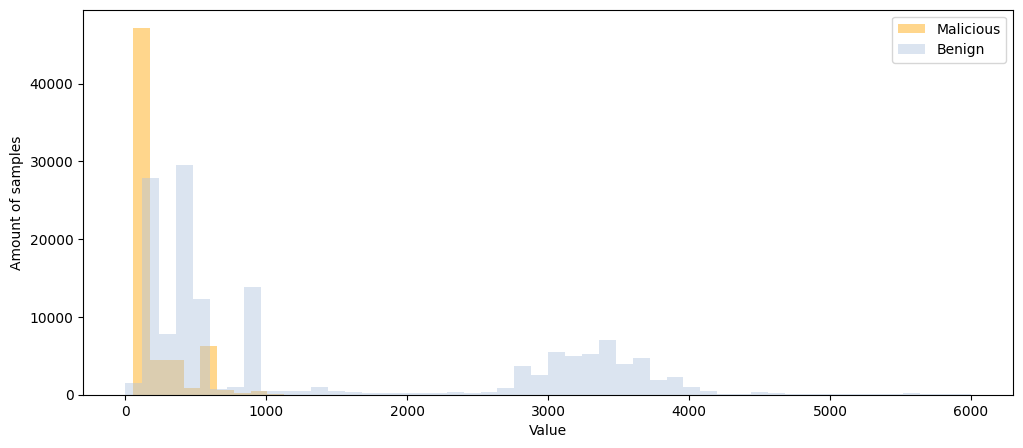

In [13]:
plot_packets = malicious['min_network_bytes'].loc[malicious['min_network_bytes'] < 6000]
plot_packets_benign = benign['min_network_bytes'].loc[benign['min_network_bytes'] < 6000]
compare_malicious_and_benign(plot_packets, plot_packets_benign)

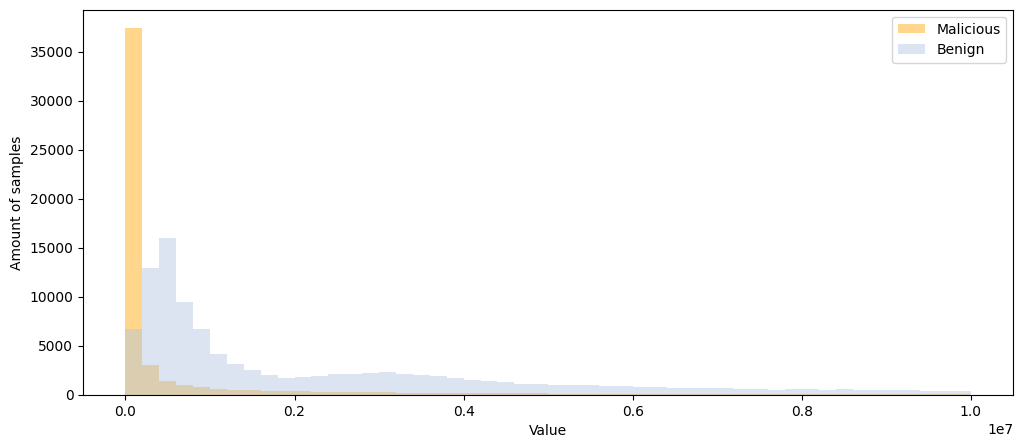

In [14]:
plot_packets = malicious['_source_event_duration'].loc[malicious['_source_event_duration'] < 10000000]
plot_packets_benign = benign['_source_event_duration'].loc[benign['_source_event_duration'] < 10000000]
compare_malicious_and_benign(plot_packets, plot_packets_benign)

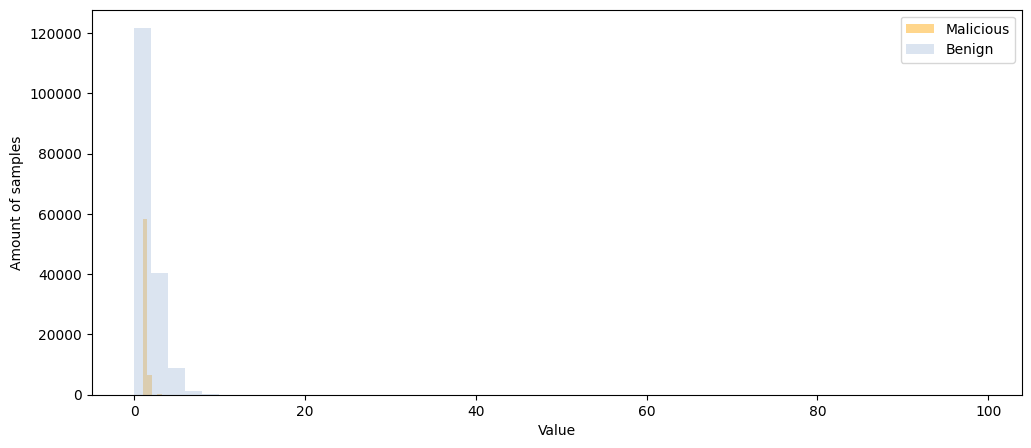

In [15]:
plot_packets = malicious['final_flow_count'].loc[malicious['final_flow_count'] < 100]
plot_packets_benign = benign['final_flow_count'].loc[benign['final_flow_count'] < 100]
compare_malicious_and_benign(plot_packets, plot_packets_benign)

In [16]:
# Removing all null values
all_data = all_data.dropna()
all_data.isnull().sum()

_source_event_duration       0
_source_network_bytes        0
packets                      0
min_network_bytes            0
max_network_bytes            0
min_source_event_duration    0
max_source_event_duration    0
final_flow_count             0
duration                     0
label                        0
dtype: int64

In [17]:
all_data.drop("packets", inplace = True, axis = 1)
all_data.drop("final_flow_count", inplace = True, axis = 1)

In [18]:
print(all_data['label'].value_counts(normalize=True))
print(all_data.dtypes)

label
0    0.726138
1    0.273862
Name: proportion, dtype: float64
_source_event_duration         int64
_source_network_bytes        float64
min_network_bytes            float64
max_network_bytes            float64
min_source_event_duration      int64
max_source_event_duration      int64
duration                     float64
label                          int64
dtype: object


In [19]:
all_data.head()

,_source_event_duration,_source_network_bytes,min_network_bytes,max_network_bytes,min_source_event_duration,max_source_event_duration,duration,label
_source_flow_id,,,,,,,,
EAL/////AP////8I//8AAAEAAAAA/////0QAQwA,0,1690.0,338.0,338.0,0,0,40000.0,0
EAL/////AP////8I//8AAAEKAAICCgACD0MARAA,503552,23288.0,592.0,924.0,0,30254,310458337.0,0
EAL/////AP////8I//8AAAEKAAIDCgACDzUA+dU,1763084,744.0,186.0,186.0,440771,440771,30005.0,0
EAL/////AP////8I//8AAAEKAAIDCgACDzUA35Y,779242764,1208.0,302.0,302.0,194810691,194810691,29912.0,0
EAL/////AP////8I//8AAAEKAAIDCgACDzUA37U,0,558.0,93.0,93.0,0,0,49906.0,0


In [20]:
def create_confusion_matrix(y_test, y_pred):	
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
    recall = float(cm[1][1]/(cm[1][0]+cm[1][1]))
    precision = float(cm[0][0]/(cm[0][0]+cm[0][1]))
    f1_score = 2 * (precision * recall) / (precision + recall)
    print("Recall: ")
    print(recall)
    print("F1 score: ")
    print(f1_score)
    disp.plot()

In [21]:
#normalizing the data (optional)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = all_data.iloc[:, :-1]
#X2 = malicious_data.iloc[:, :-1]
#y2 = malicious_data.label.values.ravel()
y = all_data.label.values.ravel()
#X2_scaled = scaler.fit_transform(X2)
print(X.dtypes)

_source_event_duration         int64
_source_network_bytes        float64
min_network_bytes            float64
max_network_bytes            float64
min_source_event_duration      int64
max_source_event_duration      int64
duration                     float64
dtype: object


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42, shuffle=True)
#X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled, y, test_size = 0.25, random_state=42, shuffle=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
callback = tf.keras.callbacks.EarlyStopping(

    monitor="val_loss",

    min_delta=0,

    patience=4,

    verbose=0,

    mode="auto",

    baseline=None,

    restore_best_weights=False

)

In [24]:
def define_create_and_compile_ann_model():
    initial_learning_rate = 0.0002
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.975,
    staircase=True)
    opt = SGD(lr=lr_schedule, momentum=0.9)
    model = keras.Sequential(
     [
     keras.layers.Dense(10, activation="relu", input_shape=(X_train.shape[-1],), kernel_regularizer=regularizers.L1(0.002), ),
     keras.layers.Dense(20, activation="relu"),
     keras.layers.Dropout(0.2),
     keras.layers.Dense(40, activation="relu"),
     keras.layers.Dropout(0.3),
     keras.layers.Dense(80, activation="relu", kernel_regularizer=regularizers.L1(0.02),),
     keras.layers.Dense(1, activation="tanh"),
     ])
    model.compile(
    optimizer=keras.optimizers.Adam(lr_schedule), 
    loss="binary_crossentropy", 
    metrics=["accuracy"]
    )
    #model.summary()
    return model

In [25]:
def alternative_ann_model():
    initial_learning_rate = 0.0005
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
    opt = SGD(lr=lr_schedule, momentum=0.8)
    model = keras.Sequential(
     [
     keras.layers.Dense(100, activation="relu", input_shape=(X_train.shape[-1],)  ),
     keras.layers.Dense(70, activation="relu"),
     keras.layers.Dropout(0.2),
     keras.layers.Dense(50, activation="relu"),
     keras.layers.Dropout(0.15), 
     keras.layers.Dense(30, activation="relu"),
     keras.layers.Dropout(0.1),
     keras.layers.Dense(10, activation="relu"),
     keras.layers.Dense(1, activation="sigmoid"),
     ])
    model.compile(
    optimizer=keras.optimizers.Adam(lr_schedule), 
    loss="binary_crossentropy", 
    metrics=["accuracy"]
    )
    #model.summary()
    return model

In [26]:
def simple_ann_model():
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
    opt = SGD(lr=lr_schedule, momentum=0.8)
    model = keras.Sequential(
     [
     keras.layers.Dense(15, activation="relu", input_shape=(X_train.shape[-1],) ),
     keras.layers.Dense(32, activation="relu"),
     keras.layers.Dense(1, activation="sigmoid"),
     ])
    model.compile(
    optimizer=keras.optimizers.Adam(lr_schedule), 
    loss="binary_crossentropy", 
    metrics=["accuracy"]
    )
    #model.summary()
    return model

In [27]:
def define_create_and_compile_autoencoders():
    n_features = X_train.shape[1]
    encoder = keras.Sequential(name='encoder')
    encoder.add(layer=layers.Dense(units=30, activation=activations.relu, input_shape=[n_features]))
    encoder.add(layers.Dropout(0.1))
    encoder.add(layer=layers.Dense(units=15, activation=activations.relu))
    encoder.add(layer=layers.Dense(units=5, activation=activations.relu))
    
    decoder = keras.Sequential(name='decoder')
    decoder.add(layer=layers.Dense(units=15, activation=activations.relu, input_shape=[5]))
    decoder.add(layer=layers.Dense(units=30, activation=activations.relu))
    decoder.add(layers.Dropout(0.1))
    decoder.add(layer=layers.Dense(units=n_features, activation=activations.sigmoid))
    
    autoencoder = keras.Sequential([encoder, decoder])
    
    autoencoder.compile(
    	loss=losses.MSE,
    	optimizer=keras.optimizers.Adam(),
        metrics=["accuracy"])

    #model.summary()
    return autoencoder 

In [28]:
def display_quality_metrics(model_name, model):
    print("Quality metrics for ", model_name)
    y_pred = model.predict(X_test)
    #y_pred2 = model.predict(X_test2)
    print(y_pred)
    create_confusion_matrix(y_test, y_pred.round())
    #create_confusion_matrix(y_test2, y_pred2.round())

In [29]:
#model = define_create_and_compile_ann_model()
model = alternative_ann_model()
#autoencoder = define_create_and_compile_autoencoders()

2023-11-23 12:38:50.058042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-23 12:38:50.393752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-23 12:38:50.393852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-23 12:38:50.402134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-23 12:38:50.402198: I tensorflow/compile

In [30]:
#history = autoencoder.fit(x=X_train, y=y_train, epochs=30, verbose=1, validation_data=[X_test, y_test], callbacks=[])

In [31]:
history = model.fit(
 X_train,
 y_train,
 batch_size=100,
 epochs=50,
 verbose = 1,
 validation_split = 0.3,
 shuffle = True,
 callbacks=[callback])

Epoch 1/50


2023-11-23 12:38:53.958812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-23 12:38:53.998640: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f803b7b5380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-23 12:38:53.998665: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-11-23 12:38:54.025899: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-23 12:38:56.231453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-11-23 12:38:56.455669: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

1248/1248 [==============================] - 11s 5ms/step - loss: 0.4461 - accuracy: 0.7742 - val_loss: 0.3951 - val_accuracy: 0.8747
Epoch 2/50
1248/1248 [==============================] - 7s 6ms/step - loss: 0.3424 - accuracy: 0.8636 - val_loss: 0.2934 - val_accuracy: 0.8888
Epoch 3/50
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3052 - accuracy: 0.8776 - val_loss: 0.2825 - val_accuracy: 0.8912
Epoch 4/50
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2952 - accuracy: 0.8821 - val_loss: 0.2687 - val_accuracy: 0.8931
Epoch 5/50
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2898 - accuracy: 0.8821 - val_loss: 0.2677 - val_accuracy: 0.8965
Epoch 6/50
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2893 - accuracy: 0.8817 - val_loss: 0.2652 - val_accuracy: 0.8938
Epoch 7/50
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2923 - accuracy: 0.8797 - val_loss: 0.2801 - val_accuracy: 0.8956
Ep

Quality metrics for  Vanilla ANN
1857/1857 [==============================] - 3s 2ms/step
[[2.5303161e-04]
 [8.7487084e-01]
 [8.6311299e-01]
 ...
 [1.8317498e-01]
 [1.5295042e-01]
 [1.6606622e-05]]
Recall: 
0.8527079363127805
F1 score: 
0.880922378125664


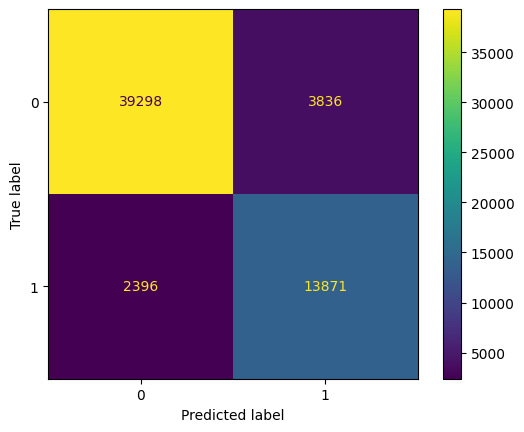

In [32]:
display_quality_metrics("Vanilla ANN", model)
#display_quality_metrics("Autoencoders", autoencoder) 

In [33]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_train)
shap.summarty_plot(shap_values, X_train, plot_type = "bar")

ValueError: masker cannot be None.